# Stacking

# Sección nueva

Realizamos los importes necesarios.

In [1]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from collections import defaultdict

from sklearn.datasets import load_iris, make_classification
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import plotly.graph_objects as go

from google.colab import files
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
colors = sns.color_palette(n_colors=15)

Bajamos los dataframes que usaremos.

In [2]:
hotels_train_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/df_hotel_v3.csv"
hotels_test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/hotels_test.csv"
df_original = pd.read_csv(hotels_train_url)
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel_test_con_is_canceled = df_hotel_test.copy()
df_hotel = df_original.copy()

Realizamos el tratamiento de datos que consideramos necesario.

In [3]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

Observamos que no hay valores faltantes.

In [4]:
num_missing = df_hotel.isna().sum()

print("El número total de valores faltantes en el DataFrame es:", num_missing.sum())

El número total de valores faltantes en el DataFrame es: 0


Con la siguiente funcion cambiaremos de algunas columnas por el valor de su media.

In [5]:
def cambiar_columna_por_probabilidad_is_canceled(columna):
  global df_hotel_test, df_hotel
  probabilidades = df_hotel.groupby(columna)['is_canceled'].mean()
  nueva_columna = columna+'_prob_is_canceled'

  df_hotel[nueva_columna] = 0
  df_hotel[nueva_columna] = df_hotel[columna].map(probabilidades)

  df_hotel_test[nueva_columna] = 0
  df_hotel_test[nueva_columna] = df_hotel_test[columna].map(probabilidades)

  mediana = df_hotel_test[nueva_columna].median()
  df_hotel_test[nueva_columna].fillna(mediana, inplace=True)

  df_hotel_test = df_hotel_test.drop(columna, axis=1)
  df_hotel = df_hotel.drop(columna, axis=1)

Lo hacemos en coutry, agent y company ya que tienen muchas columnas y realizar otro tipo de tratado de datos, como por ejemplo dummies aumenta mucho la dimensionalidad.

In [6]:
cambiar_columna_por_probabilidad_is_canceled('country')
cambiar_columna_por_probabilidad_is_canceled('agent')
cambiar_columna_por_probabilidad_is_canceled('company')

Separamos los datos y realizamos dummies de los datos restantes.

In [7]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

columns = ['hotel','arrival_date_year', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel','deposit_type', 'customer_type', 'assigned_room_type', 'reserved_room_type']

X = pd.get_dummies(X, columns=columns, drop_first=True)

df_hotel_test = pd.get_dummies(df_hotel_test, columns=columns, drop_first=True)

Completamos con las columnas necesarias.

In [8]:
columns_X = set(X.columns)
columns_test = set(df_hotel_test.columns)

missing_columns = list(columns_X - columns_test)
for column in missing_columns:
    df_hotel_test[column] = 0

df_hotel_test = df_hotel_test[X.columns]

Esta función realiza la matriz de confución con un reporte de la clasificación.

In [9]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

Creamos un conjunto de datos para el entrenamiento del modelo.

In [10]:
'''x, y = make_classification(n_samples=3000, 
                           n_features=20, 
                           n_informative=15, 
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)'''

'x, y = make_classification(n_samples=3000, \n                           n_features=20, \n                           n_informative=15, \n                           n_redundant=5,\n                           n_clusters_per_class=5,\n                           class_sep=0.7,\n                           flip_y=0.03,\n                           n_classes=2)'

In [11]:
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [12]:
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Rendimiento de diferentes modelos utilizando cv de 5',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, random_state = 42, train_size = 0.80)

In [14]:
base_models = {'random_forest':RandomForestClassifier(n_estimators=50),
               'xgb': xgb.XGBClassifier(objective='binary:logistic'),
               'knn': KNeighborsClassifier(n_neighbors=11)}

model_scores = defaultdict()

for name, model in base_models.items():
    print('Evaluando {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluando random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   49.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluando xgb


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.3min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluando knn


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   36.5s finished


In [15]:
from sklearn.ensemble import StackingClassifier

base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('xgb', xgb.XGBClassifier(objective='binary:logistic')),
               ('knn', KNeighborsClassifier(n_neighbors=11))]

meta_model = LogisticRegressionCV()

stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [16]:
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)

f1 = f1_score(y_test, y_pred_st)
accuracy = accuracy_score(y_test, y_pred_st)
precision = precision_score(y_test, y_pred_st)
recall = recall_score(y_test, y_pred_st)

print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)
print("Recall en el conjunto de prueba:", recall)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.1s finished


F1_score en el conjunto de prueba: 0.8847276264591442
Accuracy en el conjunto de prueba: 0.8843714425109774
Precision en el conjunto de prueba: 0.877613380508202
Recall en el conjunto de prueba: 0.8919581562602158


El modelo obtuvo un rendimiento bastante bueno, con un F1_score y Accuracy muy cercanos, lo que indica que el modelo está haciendo una buena clasificación en general. La precisión es ligeramente más baja que el recall, lo que sugiere que el modelo puede estar clasificando algunas instancias como negativas cuando en realidad son positivas.Igualmente, ambas métricas son bastante altas, lo que indica que el modelo tiene un buen desempeño.

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      6180
           1       0.88      0.89      0.88      6118

    accuracy                           0.88     12298
   macro avg       0.88      0.88      0.88     12298
weighted avg       0.88      0.88      0.88     12298



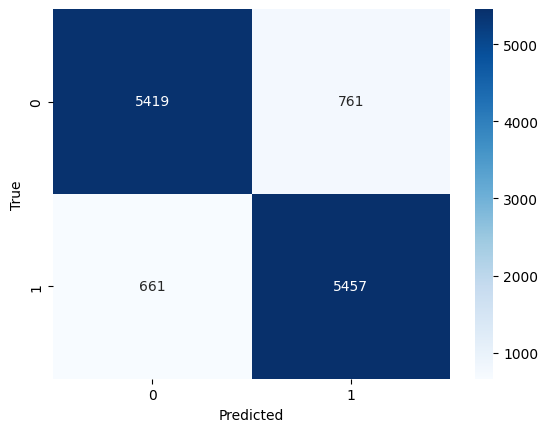

In [17]:
cm = confusion_matrix(y_test,y_pred_st)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred_st))

Observamos que a pesar de no tener un rendimiento superior a otros modelos como XGBoost o Random Forest, sigue siendo muy bueno.

In [20]:
joblib.dump(stacking_model, 'modelo_stacking_final.pkl')
loaded_model = joblib.load('modelo_stacking_final.pkl')
predicciones = loaded_model.predict(df_hotel_test)

In [21]:
df_sub = pd.DataFrame({'id': df_hotel_test_con_is_canceled['id'], 'is_canceled': predicciones})
df_sub.to_csv('prediccion_stacking_final.csv', index=False)